#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Multi-Label Classification`:
##### How well can we classify a restaurant’s cuisine type using the content of their reviews as input?

#### Group:
- `Laura Matias (20221836)`
- `Marta Almendra (20221878)`
- `Marta Aliende (20241453)`
- `Matilde Casimiro (20221940)` 
- `Teresa Simão (20221873)` 

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Data Preparation and Understanding](#p1)
    - [1.1. Restaurants Dataset](#P3)
    - [1.2. Reviews Dataset](#P3)
    - [1.3. Data Cleaning and Pre-Processing](#P3)
       
- [2. Vectorization](#p2) 
    - [2.1. Using BOW Vectorizer](#P3)
    - [2.2. Using TF-IDF Vectorizer](#P3)

- [3. Additional Visualizations](#P3)

- [4. Multilabel Classification (Information Requirement 3311)](#P3)
    - [4.1 Specific Data Preparation](#P31)
    - [4.2 Model Implementation and Evaluation](#P32)
        - [4.2.1 Decision Tree](#P32)
        - [4.2.2 Logistic Regression](#P32)
        - [4.2.3 Naive Bayes](#P32)

    - [4.3 Final Model](#P3n)

<font color='#BFD72F' size=4> Import libraries</font> <a class="anchor" id="P"></a>

In [46]:
#General Purpose
import pandas as pd
import numpy as np 
import time
import re
import string
import spacy
import random
from scipy.sparse import save_npz
import pickle

#Preprocessing
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
sent_tokenizer = PunktSentenceTokenizer()
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from collections import defaultdict
from collections import Counter
from num2words import num2words


#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import os
import networkx as nx
from tqdm import tqdm
tqdm.pandas()

#Classification and Metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# Functions
from project_utils import *

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font color='#BFD72F' size=4> Import data to a dataframe</font> <a class="anchor" id="P"></a>

In [47]:
restaurants = pd.read_csv("data_hyderabad/105_restaurants.csv", header=0)

In [48]:
reviews = pd.read_csv("data_hyderabad/10k_reviews.csv", header=0)

<font color='#BFD72F' size=6>1. Data Preparation and Understanding </font> <a class="anchor" id="p1"></a>
  
[Back to TOC](#toc)

We will conduct initial data exploration and preprocessing in both datasets separately.

<font color='#BFD72F' size=5> 1.1. Restaurants Dataset</font> <a class="anchor" id="P"></a>

In [49]:
restaurants.head(5)

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [50]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


In [51]:
# This dataset has 105 observations and 6 columns with type object.
# Only 2 variables have nulls, Timings with only one and Collections on aprox half observations
# (we will delete it has it has more that 20% missing data )
restaurants.drop(columns=['Collections'], inplace=True)

<font color='#BFD72F' size=4> 1.1.1. Missing Values</font> <a class="anchor" id="P"></a>

In [52]:
restaurants[restaurants['Timings'].isna()]

,Name,Links,Cost,Cuisines,Timings
30,Pot Pourri,https://www.zomato.com/hyderabad/pot-pourri-ga...,900,"Andhra, South Indian, North Indian",NaN


<font color='#BFD72F' size=4> 1.1.2. Duplicate Values</font> <a class="anchor" id="P"></a>

In [53]:
restaurants[restaurants.duplicated()]
#There are no duplicated values on the restaurants dataset.

,Name,Links,Cost,Cuisines,Timings


<font color='#BFD72F' size=4> 1.1.3. Data Types</font> <a class="anchor" id="P"></a>

In [54]:
restaurants['Cost'] = restaurants['Cost'].str.replace(',', '').astype(int)

In [55]:
restaurants["Cuisines"] = restaurants["Cuisines"].apply(lambda content : re.split(",",re.sub("\s","",content)))

In [56]:
label_list = []
for idx in range(len(restaurants)):
    for genre in restaurants["Cuisines"].iloc[idx]:
        if genre not in label_list:
            label_list.append(genre)

len(label_list)

44

In [57]:
restaurants['Timings'].unique()

array(['12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)', '11 AM to 11 PM',
       '11:30 AM to 4:30 PM, 6:30 PM to 11 PM', '12 Noon to 2 AM',
       '12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12noon to 12midnight (Fri-Sat)',
       '12Noon to 3:30PM, 4PM to 6:30PM, 7PM to 11:30PM (Mon, Tue, Wed, Thu, Sun), 12Noon to 3:30PM, 4PM to 6:30PM, 7PM to 12Midnight (Fri-Sat)',
       '7 AM to 10 PM', '12 Noon to 12 Midnight',
       '10 AM to 1 AM (Mon-Thu), 10 AM to 1:30 AM (Fri-Sun)',
       '12 Noon to 3:30 PM, 7 PM to 10:30 PM',
       '12 Noon to 3:30 PM, 6:30 PM to 11:30 PM', '11:30 AM to 1 AM',
       '12noon to 12midnight (Mon-Sun)',
       '12 Noon to 4:30 PM, 6:30 PM to 11:30 PM', '12 Noon to 10:30 PM',
       '12 Noon to 11 PM', '12:30 PM to 10 PM (Tue-Sun), Mon Closed',
       '11:30 AM to 3 PM, 7 PM to 11 PM',
       '11am to 11:30pm (Mon, Tue, Wed, Thu, Sun), 11am to 12midnight (Fri-Sat)',
       '10 AM to 5 AM',
       '12 Noon to 12 Midnight (Mon-Thu, Sun), 12 Noon to 1 AM (Fri-S

In [58]:
# Normalize in noon and midnight terms
restaurants['Timings'] = restaurants['Timings'].str.replace('noon', 'PM', case=False)
restaurants['Timings'] = restaurants['Timings'].str.replace('midnight', 'AM', case=False)
restaurants['Timings'] = restaurants['Timings'].str.replace('am', 'AM', case=False)
restaurants['Timings'] = restaurants['Timings'].str.replace('pm', 'PM', case=False)

In [59]:
times_split(restaurants['Timings'], restaurants)

In [60]:
restaurants.head(5)

,Name,Links,Cost,Cuisines,Timings,Open_Hours,Open_Days
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"[Chinese, Continental, Kebab, European, SouthI...","12PM to 3:30PM, 6:30PM to 11:30PM (Mon-Sun)","12PM to 3:30PM, 6:30PM to 11:30PM",Mon-Sun
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,"[Biryani, NorthIndian, Chinese]",11 AM to 11 PM,11 AM to 11 PM,None
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,1300,"[Asian, Mediterranean, NorthIndian, Desserts]","11:30 AM to 4:30 PM, 6:30 PM to 11 PM","11:30 AM to 4:30 PM, 6:30 PM to 11 PM",None
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,"[Biryani, NorthIndian, Chinese, Seafood, Bever...",12 PM to 2 AM,12 PM to 2 AM,None
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,1200,"[Asian, Continental, NorthIndian, Chinese, Med...","12PM to 11PM (Mon, Tue, Wed, Thu, Sun), 12PM t...",12PM to 11PM. 12PM to 12AM,"Mon, Tue, Wed, Thu, Sun. Fri-Sat"


In [61]:
restaurants['Open_Days'] = restaurants['Open_Days'].apply(transform_open_days)

In [62]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        105 non-null    object
 1   Links       105 non-null    object
 2   Cost        105 non-null    int32 
 3   Cuisines    105 non-null    object
 4   Timings     104 non-null    object
 5   Open_Hours  104 non-null    object
 6   Open_Days   33 non-null     object
dtypes: int32(1), object(6)
memory usage: 5.5+ KB


In [63]:
restaurants.describe()

,Cost
count,105.000000
mean,861.428571
std,510.149730
min,150.000000
25%,500.000000
50%,700.000000
75%,1200.000000
max,2800.000000


Visual Understanding

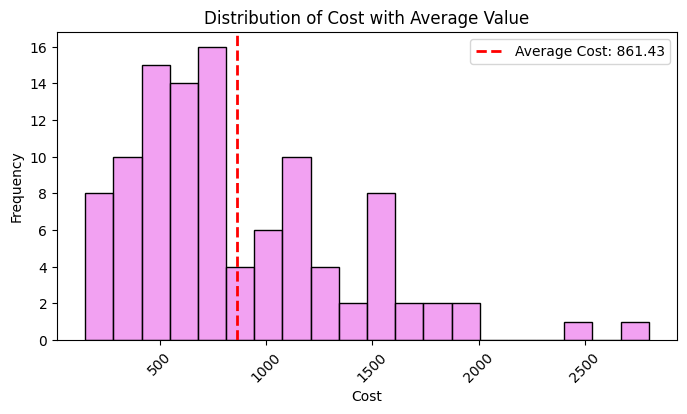

In [64]:
plot_histogram(restaurants, 'Cost', bins=20, color='violet', title='Distribution of Cost with Average Value', xlabel='Cost', ylabel='Frequency', avg_line=True)

In [65]:
# export restaurants dataset for sentiment analysis 
#restaurants.to_csv("data_hyderabad/105_restaurants_cleaned.csv", index=False)

<font color='#BFD72F' size=5> 1.2. Reviews Dataset</font> <a class="anchor" id="P"></a>

In [66]:
reviews.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [67]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [68]:
# 10000 observation and 7 (columns 6 of them with object type and one int64 (Pictures).
# Except the variables Restaurant and Pictures  the othe variables have some nulls values.

<font color='#BFD72F' size=4> 1.2.1. Data Types</font> <a class="anchor" id="P"></a>

In [69]:
reviews['Rating'].unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like', nan],
      dtype=object)

In [70]:
reviews[reviews['Rating'] == 'Like']

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
7601,The Old Madras Baking Company,Dhanasekar Kannan,One of the best pizzas to try. It served with ...,Like,"12 Reviews , 21 Followers",5/18/2019 12:31,1


Given that our dataset contains only one observation with a non-standard rating (“like” instead of a numeric value from 1 to 5), and considering the review is highly positive, we have decided to convert this “like” to a rating of 5. This adjustment ensures consistency in our dataset while accurately reflecting the positive sentiment expressed in the review.

In [71]:
reviews.loc[reviews['Rating'] == 'Like', 'Rating'] = 5

In [72]:
reviews['Rating'] = reviews['Rating'].astype('float64')

reviews['Time'] = pd.to_datetime(reviews['Time'])

<font color='#BFD72F' size=4> 1.2.2. Missing Values</font> <a class="anchor" id="P"></a>

In [73]:
rows_missing = reviews[reviews.isnull().any(axis=1)]
rows_missing.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
2360,Amul,Lakshmi Narayana,NaN,5.0,0 Reviews,2018-07-29 18:00:00,0
5799,Being Hungry,Surya,NaN,5.0,"4 Reviews , 4 Followers",2018-07-19 23:55:00,0
6449,Hyderabad Chefs,Madhurimanne97,NaN,5.0,1 Review,2018-07-23 16:29:00,0
6489,Hyderabad Chefs,Harsha,NaN,5.0,1 Review,2018-07-08 21:19:00,0
7954,Olive Garden,ARUGULLA PRAVEEN KUMAR,NaN,3.0,"1 Review , 1 Follower",2018-08-09 23:25:00,0


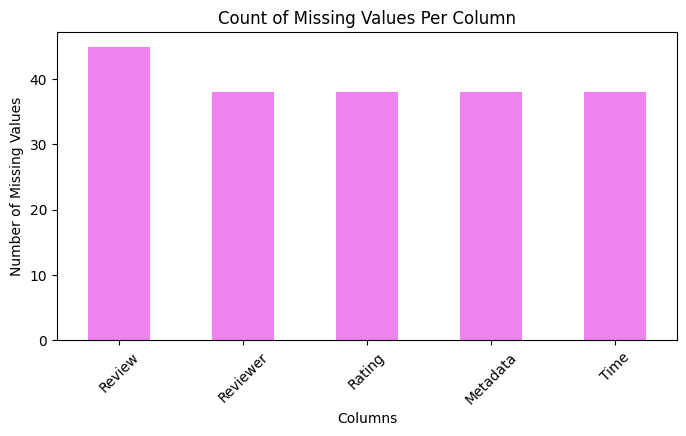

In [74]:
missing_counts = reviews.isnull().sum()
plot_bar(missing_counts[missing_counts > 0].sort_values(ascending=False), title="Count of Missing Values Per Column", xlabel="Columns", ylabel="Number of Missing Values", color='violet')


In [75]:
percentage_missing = round((len(rows_missing) / len(reviews)) * 100 , 2)

print(f"Percentage of rows with missing values: {percentage_missing}%")

Percentage of rows with missing values: 0.45%


The percentage of rows in the dataframe with missing values is very reduced, so we can exclude these few observations from the dataset.

In [76]:
reviews = reviews.dropna(subset=['Review'])

<font color='#BFD72F' size=4> 1.2.2. Duplicate Values</font> <a class="anchor" id="P"></a>

In [77]:
reviews[reviews.duplicated()]

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures


There are no duplidate rows in the dataset.

<font color='#BFD72F' size=4> 1.2.3. Data Transformations</font> <a class="anchor" id="P"></a>

We transformed the column 'Metadata' into two separate columns: 'Number_Reviews' and 'Followers'.

In [78]:
reviews['Number_Reviews'] = reviews['Metadata'].str.extract(r'(\d+)\s*Reviews?').astype('Int64')
reviews['Followers'] = reviews['Metadata'].str.extract(r'(\d+)\s*Followers?').astype('Int64')

In [79]:
reviews[reviews['Followers'].isnull()]

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Number_Reviews,Followers
5,Beyond Flavours,Nagabhavani K,"Ambiance is good, service is good, food is aPr...",5.0,1 Review,2019-05-24 15:22:00,0,1,<NA>
6,Beyond Flavours,Jamuna Bhuwalka,"Its a very nice place, ambience is different, ...",5.0,1 Review,2019-05-24 01:02:00,0,1,<NA>
7,Beyond Flavours,Sandhya S,Well after reading so many reviews finally vis...,4.0,1 Review,2019-05-23 15:01:00,0,1,<NA>
14,Beyond Flavours,Kankaria.ritu,"We ordered corn cheese balls, manchow soup and...",1.0,1 Review,2019-05-22 21:19:00,0,1,<NA>
24,Beyond Flavours,Amritap Datta,"Excellent experience, mouthwatering food, good...",5.0,1 Review,2019-05-20 23:33:00,0,1,<NA>
...,...,...,...,...,...,...,...,...,...
9912,Chinese Pavilion,Anil Rao,The tofu with mushrooms was absolutely wonderf...,5.0,9 Reviews,2019-04-04 02:15:00,0,9,<NA>
9918,Chinese Pavilion,Ajay Munjal,The food is delicious. Service is excellent. I...,5.0,4 Reviews,2019-02-16 13:56:00,0,4,<NA>
9933,Chinese Pavilion,Korak Mukherjee,I was here last night with 2 of my friends. We...,1.0,9 Reviews,2018-05-29 16:02:00,1,9,<NA>
9940,Chinese Pavilion,Anubinda Dash,The food was amazing. Do not forget to try 'Mo...,4.5,11 Reviews,2018-03-02 19:54:00,10,11,<NA>


In [80]:
reviews[reviews['Number_Reviews'].isnull()]

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Number_Reviews,Followers
3410,Mazzo - Marriott Executive Apartments,Vidushi Mittal,On the B-day I was looking for a place which h...,4.0,"1 Post , 80 Followers",2019-05-04 18:27:00,14,<NA>,80
5347,Diners Pavilion,Atulmaharaj,We went on a Monday for dinner and there was h...,4.0,"89 Posts , 1127 Followers",2018-10-06 07:50:00,3,<NA>,1127
5830,Tempteys,Swati Nandy,The Caramel Brownie was one of my favorites. T...,4.0,"82 Posts , 1500 Followers",2018-09-19 11:05:00,0,<NA>,1500
7375,Driven Cafe,ChicLifeByte,"If bikes, cars and coffee are your weaknesses ...",5.0,"151 Posts , 2709 Followers",2018-06-10 09:48:00,34,<NA>,2709
9683,Hyderabadi Daawat,Hyderabadfoodexplorer (sanchay Gumidelli),"So the place is named as Hyderabadi Daawat, is...",4.0,"47 Posts , 4142 Followers",2018-10-31 22:29:00,28,<NA>,4142
9981,Chinese Pavilion,Karthik Gandhi,Chinese Cuisine including diverse styles from ...,4.5,"88 Posts , 1694 Followers",2016-10-11 10:10:00,15,<NA>,1694


If the values for the column 'Followers' is missing, we can assume that the restaurant has 0 followers.

In [81]:
reviews['Followers'] = reviews['Followers'].fillna(0)

In [82]:
reviews.drop(columns=['Metadata'], inplace=True)

In [83]:
# export reviews dataset for sentiment analysis 
#reviews.to_csv("data_hyderabad/10k_reviews_cleaned_no_pre_proc.csv", index=False)

Visual Understanding

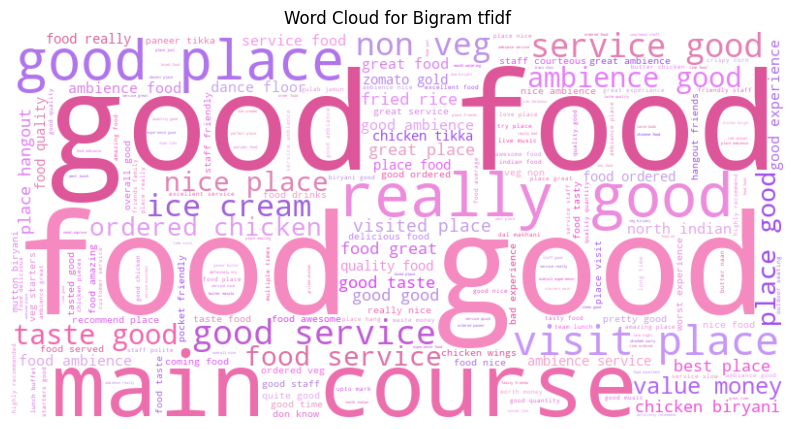

In [84]:
wordcloud_generator(reviews, 'Review')

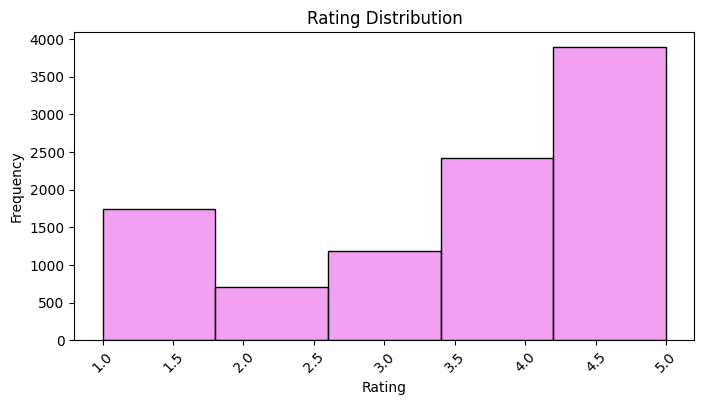

In [85]:
plot_histogram(reviews, 'Rating', bins=5, color='violet', title="Rating Distribution", xlabel="Rating", ylabel="Frequency", avg_line=False)

<font color='#BFD72F' size=4> 1.3. Data Cleaning and Pre-Processing </font> <a class="anchor" id="P"></a>

Removing noise, irrelevant information and formatting artifacts that interfered with our analysis. 
The following steps were taken: 

- Removing Punctuation
- Removing URLs
- Removing HTML tags
- Removing whitespace 
- Handling Special Characters : emojis, @ , # , etc.
- Converting numbers into their word form (5 -> 'five') , and handling specific cases (example: 3.5/5 -> three point five out of five ; 1* -> one star)
- Correct repeated letters

Following an initial data cleaning, steps were taken in order to do data normalization (lower case normalization), tokenization, stopword removal (in exception to negation words), lemmatization.

In [86]:
clean_reviews = reviews.copy()

In [ ]:
clean_reviews['cleaned_reviews'], clean_reviews['tokenized'] = zip(*clean_reviews['Review'].map(text_pre_process_pipeline))

In [88]:
clean_reviews[['Review', 'cleaned_reviews']].sample(5)

,Review,cleaned_reviews
8673,Good combo,good combo
8068,"if u r to order anything from them, just add a...",order anything add extra quantity even serve t...
1043,Food here is decent for the price paid. Paneer...,food decent price pay paneer paratha awesome h...
4584,Good good. quantity is little less,good good quantity little less
7052,"Ambience decent , parking to the place is an i...",ambience decent parking place issue tom yum so...


<font color='#BFD72F' size=4> 1.3.1 Other Adjustments</font> <a class="anchor" id="P"></a>

In [89]:
clean_reviews = pd.merge(clean_reviews, restaurants[['Name', 'Cuisines']], left_on='Restaurant', right_on='Name', how='left')
clean_reviews.drop(columns=['Name'], inplace=True)

In [90]:
clean_reviews["review_len"] = clean_reviews["Review"].map(lambda content : len(str(content)))
clean_reviews["sents"] = clean_reviews["Review"].map(lambda content :\
                                                                  sent_tokenizer.tokenize(str(content))).map(lambda content : len(content))

<font color='#BFD72F' size=4> 1.3.2 Possible Inconsistency</font> <a class="anchor" id="P"></a>

We discovered that when adding Cuisine Types to clean_reviews, even though in the restaurant data there were 44 different cuisine types, after merging we only found 42.

We investigated and discovered that the Republic Of Noodles - Lemon Tree Hotel restaurant (Mithai cuisine) and Sweet Basket restaurant (Malaysian cuisine) , seemed to not have any reviews regarding them, even though their name was present in the restaurant dataset.

Being these restaurants the only ones associated to their respective cuisine types (Mithai, Malaysian), and them not appearing in the reviews dataset, we only considered the remaining 42 cuisines available, by overwritting the label_list to only represent them.

In [91]:
label_list = []
for idx in range(len(clean_reviews)):
    for genre in clean_reviews["Cuisines"].iloc[idx]:
        if genre not in label_list:
            label_list.append(genre)
len(label_list)

42

In [92]:
reviews[reviews['Restaurant'] == 'Republic Of Noodles - Lemon Tree Hotel']

,Restaurant,Reviewer,Review,Rating,Time,Pictures,Number_Reviews,Followers


In [93]:
reviews[reviews['Restaurant'] == 'Sweet Basket']

,Restaurant,Reviewer,Review,Rating,Time,Pictures,Number_Reviews,Followers


<font color='#BFD72F' size=6>2. Vectorization </font> <a class="anchor" id="p1"></a>
  
[Back to TOC](#toc)


In this section we encode our textual data into numbers, with methods such as Bag of Words (BOW), TF-IDF.


We decided to investigate if it was possible to remove unimportant tokens based on their frequency, tokens that appeared less frequently (typos) and the ones that appear more frequently, since they wouldn't be helpful in differentiating between cuisine types.

We investigated the top common words, and the less common to confirm if they should in fact be removed.

- Check and remove very uncommon words

In [94]:
clean_reviews, removed_words = remove_rare_words_min_df(clean_reviews, 'cleaned_reviews', min_df=0.002)
#print("Words removed:", removed_words)

- Check and remove very common words (custom top 50)

In [95]:
all_words = ' '.join(clean_reviews['cleaned_reviews']).split()
word_counts = Counter(all_words)
top_50_words = [word for word, count in word_counts.most_common(50)]
words_to_keep = ['chicken', 'biryani', 'veg', 'no', 'not', 'rice', 'nice', 'bad', 'price', 'quality', 'staff', 'amazing', 'really']

In [96]:
# Filter top words except for the words to keep
clean_reviews['cleaned_reviews_reduced_words'] = clean_reviews['cleaned_reviews'].apply(
    lambda text: ' '.join([word for word in text.split() 
                           if word not in top_50_words or word in words_to_keep]))

print("Top 50 Words Removed (Except Kept Words):", set(top_50_words) - set(words_to_keep))

Top 50 Words Removed (Except Kept Words): {'three', 'starter', 'time', 'good', 'five', 'friend', 'order', 'make', 'love', 'food', 'ambience', 'visit', 'try', 'place', 'like', 'also', 'four', 'awesome', 'two', 'I', 'give', 'great', 'go', 'take', 'taste', 'experience', 'even', 'restaurant', 'dish', 'would', 'well', 'must', 'serve', 'one', 'come', 'service', 'get'}


<font color='#BFD72F' size=4> 2.1. BOW Vectorizer </font> <a class="anchor" id="P"></a>

In [97]:
clean_reviews, bow_vectorizer, bow_matrix = vectorization(
    clean_reviews,
    text_column='cleaned_reviews_reduced_words',
    vector_column_name = 'bow',
    vectorizer_type='bow', 
    ngram_range=(1, 1),
    binary=False)
clean_reviews.head(1)

,Restaurant,Reviewer,Review,Rating,Time,Pictures,Number_Reviews,Followers,cleaned_reviews,tokenized,Cuisines,review_len,sents,cleaned_reviews_reduced_words,bow
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,2019-05-25 15:54:00,0,1,2,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...","[Chinese, Continental, Kebab, European, SouthI...",222,5,quite saturday lunch cost effective sate brunc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<font color='#BFD72F' size=4> 2.2. TF-IDF </font> <a class="anchor" id="P"></a>

In [98]:
clean_reviews, tfidf_vectorizer, tf_idf_matrix = vectorization(
    clean_reviews,
    text_column='cleaned_reviews_reduced_words',
    vector_column_name = 'tfidf',
    vectorizer_type='tfidf',
    ngram_range=(1, 1))
clean_reviews.head(1)

,Restaurant,Reviewer,Review,Rating,Time,Pictures,Number_Reviews,Followers,cleaned_reviews,tokenized,Cuisines,review_len,sents,cleaned_reviews_reduced_words,bow,tfidf
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,2019-05-25 15:54:00,0,1,2,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...","[Chinese, Continental, Kebab, European, SouthI...",222,5,quite saturday lunch cost effective sate brunc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<font color='#BFD72F' size=6>3. Additional Visualizations </font> <a class="anchor" id="p2"></a>
  
[Back to TOC](#toc)

<font color='#BFD72F' size=4> 3.1. Cuisine Type Frequency in Reviews </font> <a class="anchor" id="P"></a>

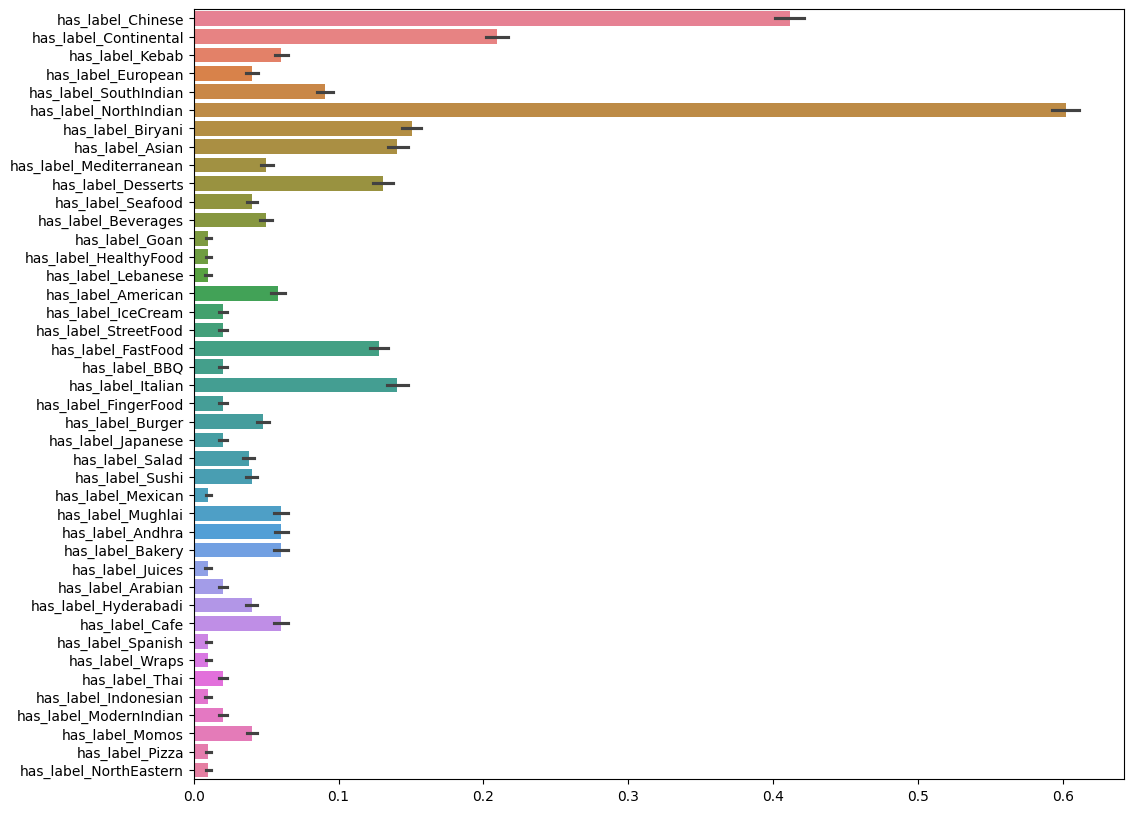

In [99]:
clean_reviews_explore = pd.DataFrame()
clean_reviews_explore["cleaned_reviews"] = clean_reviews["cleaned_reviews"]
clean_reviews_explore["cleaned_reviews_reduced_words"] = clean_reviews["cleaned_reviews_reduced_words"]

for label in label_list:
    clean_reviews_explore["has_label_{}".format(label)] = clean_reviews["Cuisines"].map(lambda labels_list : 1 if label in labels_list else 0)

plt.figure(figsize=(12, 10))
sns.barplot(clean_reviews_explore, orient="h")
plt.show()

<font color='#BFD72F' size=4> 3.2. Word Clouds </font> <a class="anchor" id="P"></a>

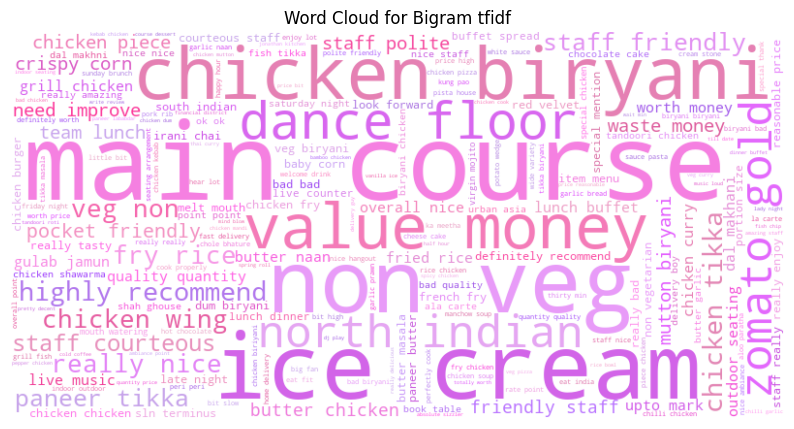

In [100]:
wordcloud_generator(clean_reviews, 'cleaned_reviews_reduced_words', 'tfidf')

#### WorldClouds by Type of Cuisine

WordClouds by Cuisine After Pre-processing

Output's are available in the WordClouds_before folder.

In [101]:
'''
wordcloud_generator(
    data=clean_reviews_explore,
    column='cleaned_reviews',
    unique_labels=label_list,
    vectorisation='tfidf',
    export=True,
    before=True)
'''

"\nwordcloud_generator(\n    data=clean_reviews_explore,\n    column='cleaned_reviews',\n    unique_labels=label_list,\n    vectorisation='tfidf',\n    export=True,\n    before=True)\n"

WordClouds by Cuisine after Pre-processing and Feature Extraction

Output's are available in the WordClouds_after folder.

In [102]:
'''
wordcloud_generator(
    data=clean_reviews_explore,
    column='cleaned_reviews_reduced_words',
    unique_labels=label_list,
    vectorisation='tfidf',
    export=True,
    before=False)
'''

"\nwordcloud_generator(\n    data=clean_reviews_explore,\n    column='cleaned_reviews_reduced_words',\n    unique_labels=label_list,\n    vectorisation='tfidf',\n    export=True,\n    before=False)\n"

<font color='#BFD72F' size=4> 3.3. Donut Chart </font> <a class="anchor" id="P"></a>

In [103]:
donut_chart(clean_reviews, 'cleaned_reviews_reduced_words')

<font color='#BFD72F' size=4> 3.4. Tree Chart </font> <a class="anchor" id="P"></a>

Preprocessed Reduced Words Reviews

In [104]:
tree_map(clean_reviews, 'cleaned_reviews_reduced_words')

<font color='#BFD72F' size=4> 3.5. Tokens Co-occurrence  </font> <a class="anchor" id="P"></a>

- Co-occurence in pre-processed reviews

In [105]:
reviews_co_occurrence = cooccurrence_matrix_review_generator(clean_reviews["tokenized"].tolist())

100%|██████████| 9955/9955 [00:14<00:00, 683.90it/s] 


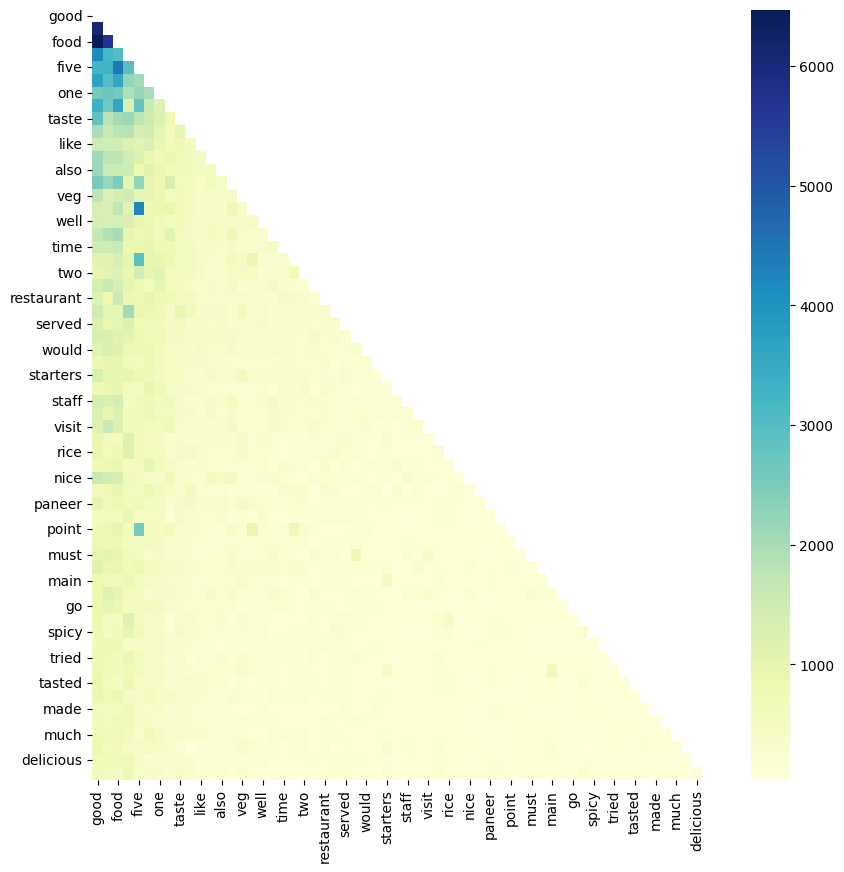

In [106]:
# Create a mask for the upper triangle, but leave the diagonal elements as True
mask = np.triu(np.ones_like(reviews_co_occurrence.iloc[:60, :60], dtype=bool))

# Create heatmap from the co-occurrence matrix using 
plt.figure(figsize=(10,10))
sns.heatmap(reviews_co_occurrence.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

In [107]:
reviews_co_occurrence_window = cooccurrence_matrix_window_generator(clean_reviews["tokenized"].tolist(),2)

100%|██████████| 9955/9955 [00:02<00:00, 4341.86it/s]


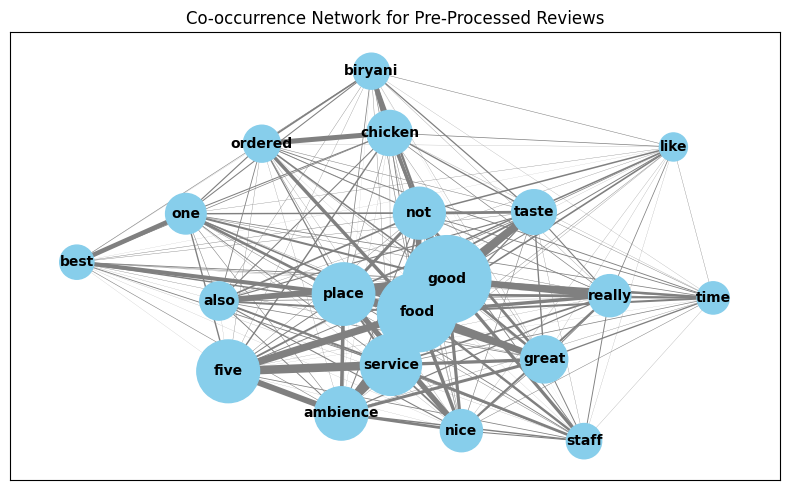

In [108]:
cooccurrence_network_generator(
    cooccurrence_matrix_df=reviews_co_occurrence_window,
    label="Pre-Processed Reviews", 
     figsize=(8, 5))

- Co-occurence in pre-processed reviews with reduced words

In [109]:
clean_reviews['tokenized_reduced'] = clean_reviews['cleaned_reviews_reduced_words'].apply(lambda x: x.split())

reviews_reduced_co_occurrence = cooccurrence_matrix_review_generator(clean_reviews['tokenized_reduced'].tolist())
reviews_reduced_co_occurrence_window = cooccurrence_matrix_window_generator(clean_reviews['tokenized_reduced'].tolist(), 2)

100%|██████████| 9955/9955 [00:01<00:00, 9526.27it/s] 


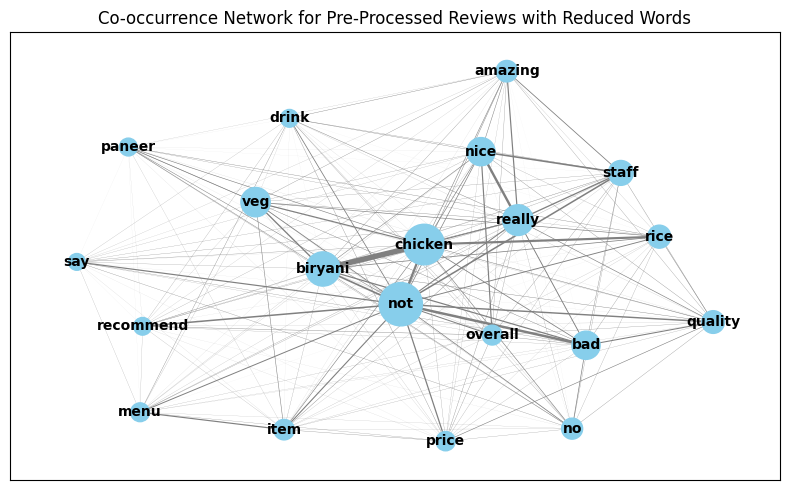

In [110]:
cooccurrence_network_generator(
    cooccurrence_matrix_df=reviews_reduced_co_occurrence_window,
    label="Pre-Processed Reviews with Reduced Words", 
     figsize=(8, 5))

In [111]:
#clean_reviews.to_pickle("clean_reviews.pkl")

<font color='#BFD72F' size=6>4. Modelling </font> <a class="anchor" id="p2"></a>
  
[Back to TOC](#toc)

<font color='#BFD72F' size=4> 4.1 Specific Data Preparation  </font> <a class="anchor" id="P"></a>

In [112]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(clean_reviews['Cuisines'])
clean_reviews['labels'] = binarised_labels.tolist()

Data Split with Bow:

In [113]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    bow_matrix, binarised_labels, test_size=0.2, random_state=42)

Data Split with Tf-IDF:

In [114]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tf_idf_matrix, binarised_labels, test_size=0.2, random_state=42)

<font color='#BFD72F' size=4> 4.2 Model Implementation and Evaluation  </font> <a class="anchor" id="P"></a>

<font color='#BFD72F' size=4> 4.2.1 Decision Tree </font> <a class="anchor" id="P"></a>

In [128]:
dt_ovr = OneVsRestClassifier(DecisionTreeClassifier(random_state=42, max_depth = 30, min_samples_split = 10, min_samples_leaf = 1, class_weight= None)).fit(X_train_tfidf, y_train_tfidf)
y_pred_dt_ovr = dt_ovr.predict(X_test_tfidf)

dt_cchain = ClassifierChain(DecisionTreeClassifier(random_state=42, max_depth = 30, min_samples_split = 10, min_samples_leaf = 1, class_weight= None), order = 'random').fit(X_train_tfidf, y_train_tfidf)
y_pred_dt_cchain = dt_cchain.predict(X_test_tfidf)

In [129]:
y_pred_dtovr_train = dt_ovr.predict(X_train_tfidf)
y_pred_dtchain_train = dt_cchain.predict(X_train_tfidf)

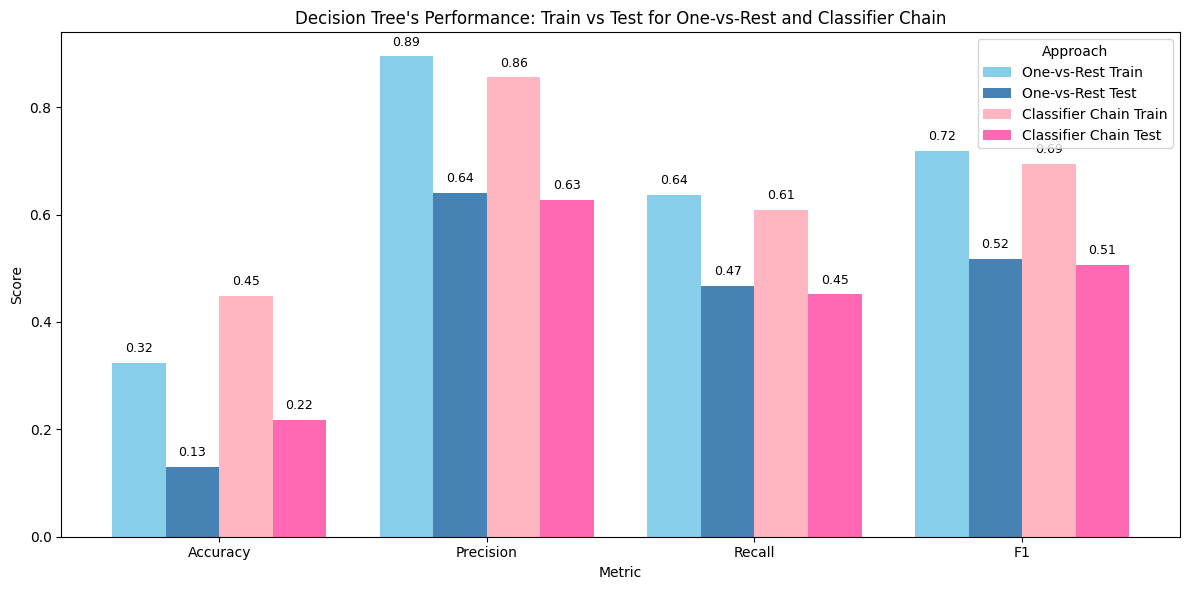

In [132]:
dt_ovr_test_metrics = fold_score_calculator(y_pred_dt_ovr, y_test_tfidf)
dt_cchain_test_metrics = fold_score_calculator(y_pred_dt_cchain, y_test_tfidf)

dt_ovr_train_metrics = fold_score_calculator(y_pred_dtovr_train, y_train_tfidf)
dt_cchain_train_metrics = fold_score_calculator(y_pred_dtchain_train, y_train_tfidf)

plot_metrics(dt_ovr_train_metrics, dt_ovr_test_metrics,dt_cchain_train_metrics, dt_cchain_test_metrics, "Decision Tree")


<font color='#BFD72F' size=4> 4.2.2 Logistic Regression </font> <a class="anchor" id="P"></a>

In [136]:
lr_ovr = OneVsRestClassifier(LogisticRegression( C =  10, class_weight = None, fit_intercept = True, max_iter =  100, penalty = 'l2', 
    solver = 'saga', tol = 0.0001)).fit(X_train_tfidf, y_train_tfidf)
y_pred_lr_ovr = lr_ovr.predict(X_test_tfidf)

lr_cchain = ClassifierChain(LogisticRegression( C =  10, class_weight = None, fit_intercept = True, max_iter =  100, penalty = 'l2',
    solver = 'saga', tol = 0.0001), order = None).fit(X_train_tfidf, y_train_tfidf)
y_pred_lr_cchain = lr_cchain.predict(X_test_tfidf)

In [137]:
y_pred_lrovr_train = lr_ovr.predict(X_train_tfidf)
y_pred_lrchain_train = lr_cchain.predict(X_train_tfidf)

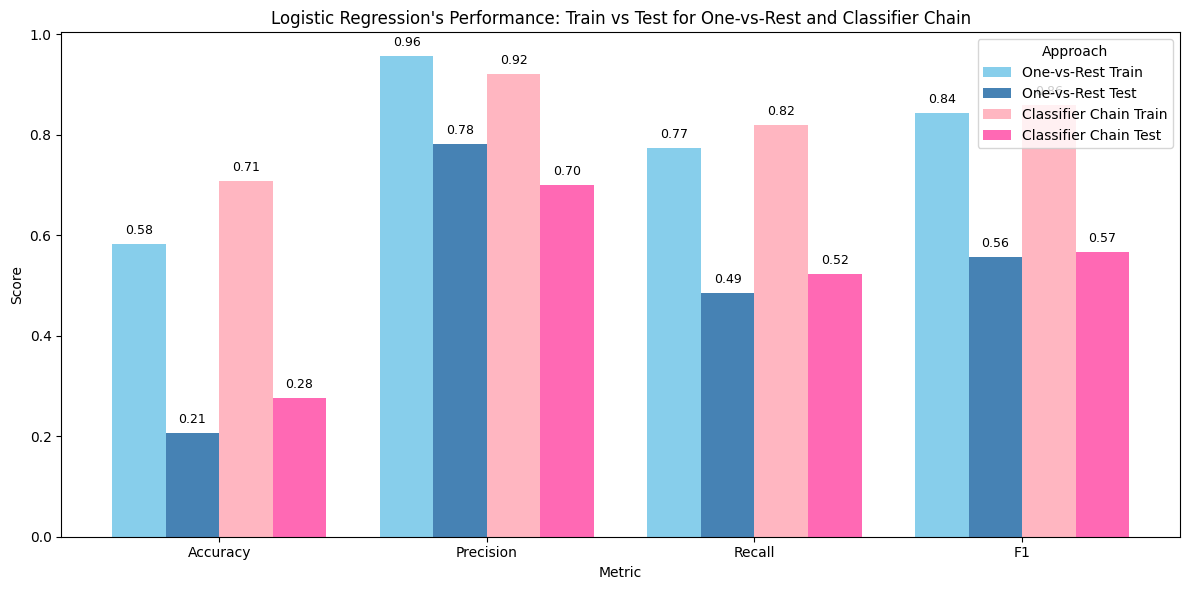

In [138]:
lr_ovr_test_metrics = fold_score_calculator(y_pred_lr_ovr, y_test_tfidf)
lr_cchain_test_metrics = fold_score_calculator(y_pred_lr_cchain, y_test_tfidf)

lr_ovr_train_metrics = fold_score_calculator(y_pred_lrovr_train, y_train_tfidf)
lr_cchain_train_metrics = fold_score_calculator(y_pred_lrchain_train, y_train_tfidf)


plot_metrics(lr_ovr_train_metrics,lr_ovr_test_metrics, lr_cchain_train_metrics,  lr_cchain_test_metrics, "Logistic Regression")

<font color='#BFD72F' size=4> 4.2.3 Naive Bayes </font> <a class="anchor" id="P"></a>

In [115]:
naive_bayes_ovr = OneVsRestClassifier(MultinomialNB(alpha=0.1)).fit(X_train_bow ,y_train_bow )
y_pred_nb_ovr = naive_bayes_ovr.predict(X_test_bow)

naive_bayes_cchain = ClassifierChain(MultinomialNB(alpha=0.1), order = 'random', random_state=42).fit(X_train_bow ,y_train_bow )
y_pred_nb_cchain = naive_bayes_cchain.predict(X_test_bow)

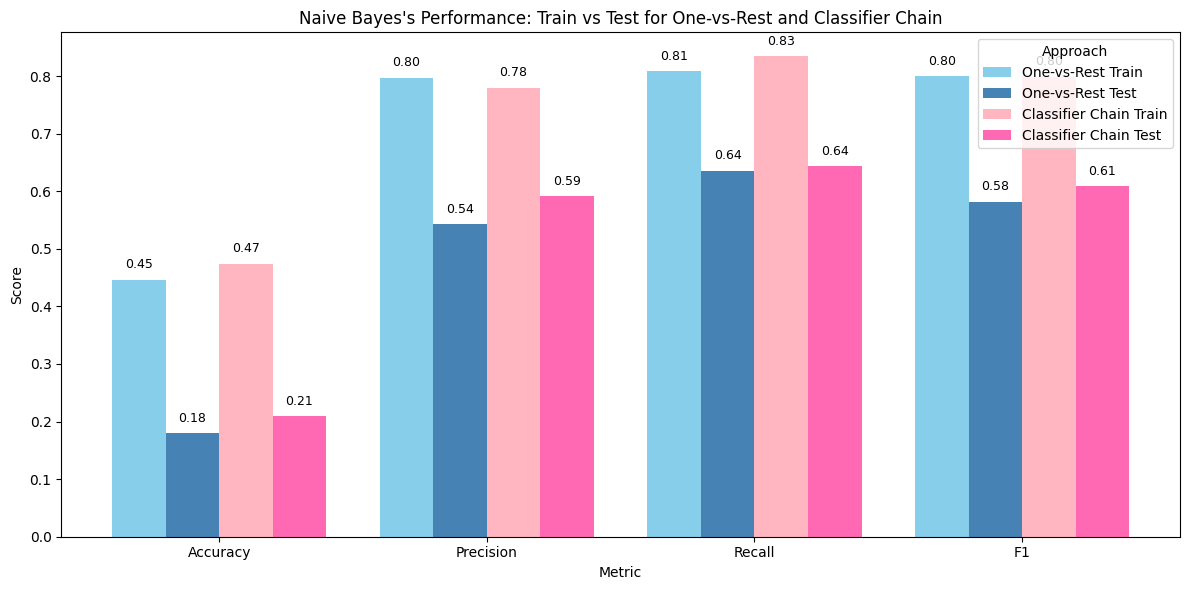

In [131]:
nb_ovr_train_metrics = fold_score_calculator(naive_bayes_ovr.predict(X_train_bow), y_train_bow)
nb_cchain_train_metrics = fold_score_calculator(naive_bayes_cchain.predict(X_train_bow), y_train_bow)

nb_ovr_test_metrics = fold_score_calculator(y_pred_nb_ovr, y_test_bow)
nb_cchain_test_metrics = fold_score_calculator(y_pred_nb_cchain, y_test_bow)

plot_metrics(nb_ovr_train_metrics, nb_ovr_test_metrics, nb_cchain_train_metrics, nb_cchain_test_metrics, "Naive Bayes")

<font color='#BFD72F' size=4> 4.3 Final Model </font> <a class="anchor" id="P"></a>

We choose Naive Bayes model, and provide the individua metrics for each label.

In [149]:
cuisine_metrics = []

for i, cuisine in enumerate(mlb.classes_):
    y_true_cuisine = y_test_bow[:, i]
    y_pred_cuisine = y_pred_nb_cchain[:, i]
    
    tn, fp, fn, tp = confusion_matrix(y_true_cuisine, y_pred_cuisine).ravel()
    
    accuracy = accuracy_score(y_true_cuisine, y_pred_cuisine)
    precision = precision_score(y_true_cuisine, y_pred_cuisine, zero_division=0)
    recall = recall_score(y_true_cuisine, y_pred_cuisine, zero_division=0)
    f1 = f1_score(y_true_cuisine, y_pred_cuisine, zero_division=0)
    
    cuisine_metrics.append({
        "Cuisine": cuisine,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "True Positives": tp,
        "True Negatives": tn,
        "False Positives": fp,
        "False Negatives": fn})

metrics_cuisines = pd.DataFrame(cuisine_metrics)

In [150]:
metrics_cuisines.sort_values(by='F1-Score', ascending=True)

,Cuisine,Accuracy,Precision,Recall,F1-Score,True Positives,True Negatives,False Positives,False Negatives
27,Mexican,0.978403,0.100000,0.157895,0.122449,3,1945,27,16
20,Indonesian,0.983928,0.307692,0.148148,0.200000,4,1955,9,23
41,Wraps,0.984430,0.363636,0.142857,0.205128,4,1956,7,24
23,Juices,0.982923,0.200000,0.263158,0.227273,5,1952,20,14
38,StreetFood,0.976896,0.318182,0.184211,0.233333,7,1938,15,31
33,Pizza,0.990457,0.400000,0.235294,0.296296,4,1968,6,13
2,Arabian,0.979407,0.375000,0.257143,0.305085,9,1941,15,26
25,Lebanese,0.974887,0.255814,0.379310,0.305556,11,1930,32,18
15,FingerFood,0.969362,0.280000,0.358974,0.314607,14,1916,36,25
34,Salad,0.955801,0.407407,0.282051,0.333333,22,1881,32,56


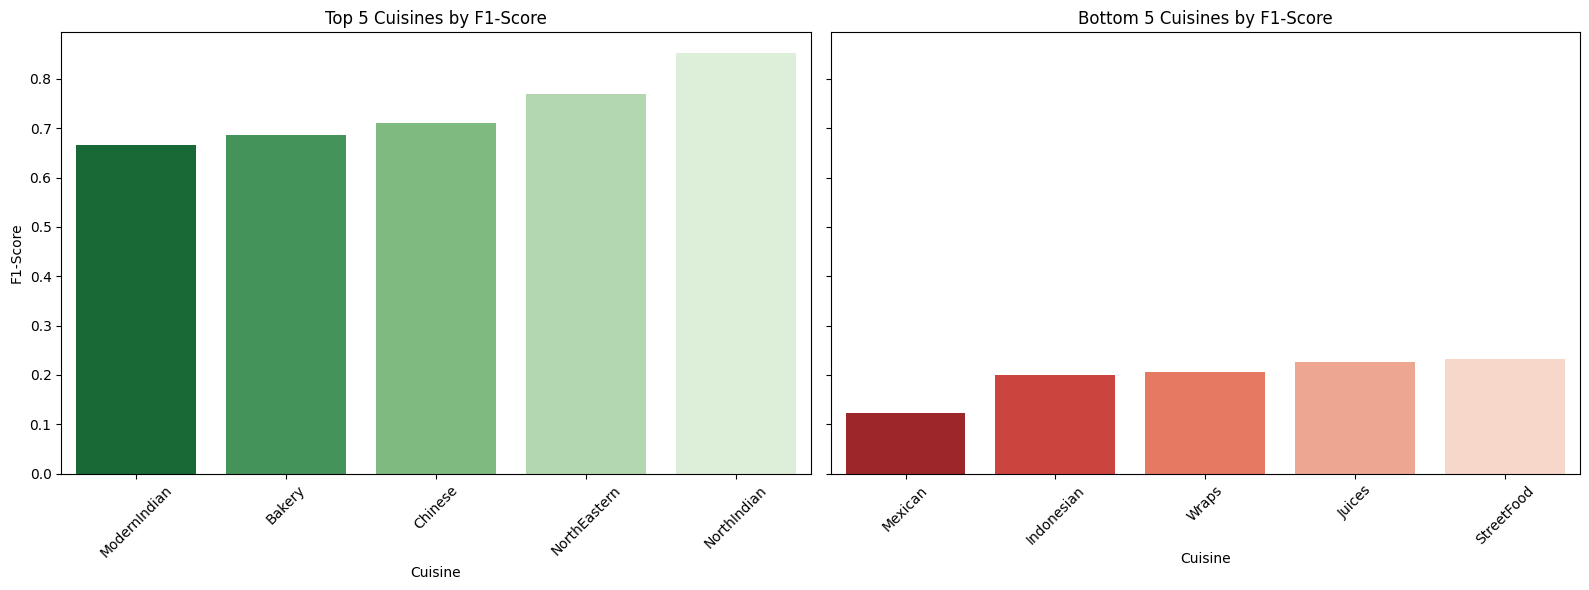

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.barplot(ax=axes[0], x="Cuisine", y="F1-Score", data=metrics_cuisines.sort_values(by='F1-Score', ascending=True).tail(5), palette="Greens_r")
axes[0].set_title('Top 5 Cuisines by F1-Score')
axes[0].set_xlabel('Cuisine')
axes[0].set_ylabel('F1-Score')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x="Cuisine", y="F1-Score", data=metrics_cuisines.sort_values(by='F1-Score', ascending=True).head(5), palette="Reds_r")
axes[1].set_title('Bottom 5 Cuisines by F1-Score')
axes[1].set_xlabel('Cuisine')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()